In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import float32

from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
tf.random.set_seed(42)

warnings.filterwarnings("ignore", category=UserWarning)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [373]:
dataset = pd.read_csv("business.csv")
dataset.head()
dataset.shape
dataset.isnull().sum()
dataset.dtypes
dataset["date"] = pd.to_datetime(dataset["date"], format='mixed')
dataset["month"] = dataset["date"].dt.month
dataset["year"] = dataset["date"].dt.year
dataset["day"] = dataset["date"].dt.day
dataset["dayofweek"] = dataset["date"].dt.dayofweek
dataset.columns
dataset.duplicated().sum()
dataset.shape

(93487, 15)

In [374]:
for data in dataset.columns:
    if dataset[data].dtype == "object":
        dataset[data] = dataset[data].astype(str)
        dataset[data] = dataset[data].str.strip()


In [375]:
for data in dataset.columns:
    if dataset[data].dtype == "object":
        print(dataset[data].groupby(dataset[data]).count().sort_values(ascending=False))
dataset["stop"] = dataset["stop"].str.replace("\n", "").str.replace("\t", "")
dataset["stop"] = dataset["stop"].str.strip()
dataset["stop"] = dataset["stop"].str.replace("stopVia", "stop Via")

airline
Vistara      60589
Air India    32898
Name: airline, dtype: int64
ch_code
UK    60589
AI    32898
Name: ch_code, dtype: int64
dep_time
07:00    3805
10:25    3560
09:45    2477
19:00    2450
20:35    2226
         ... 
22:40       7
12:40       6
05:35       4
19:35       2
14:50       1
Name: dep_time, Length: 166, dtype: int64
from
Mumbai       19858
Delhi        18316
Bangalore    16441
Kolkata      13473
Hyderabad    12870
Chennai      12529
Name: from, dtype: int64
time_taken
02h 10m    1161
02h 15m    1124
02h 45m     873
12h 25m     838
12h 05m     822
           ... 
37h 50m       1
37h 55m       1
40h 40m       1
45h 50m       1
47h 45m       1
Name: time_taken, Length: 373, dtype: int64
stop
1-stop                                             81489
non-stop                                            8102
2+-stop                                             1083
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR              810
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU              

In [376]:
dataset["price"] = dataset["price"].str.replace(',', '').astype(np.float32)

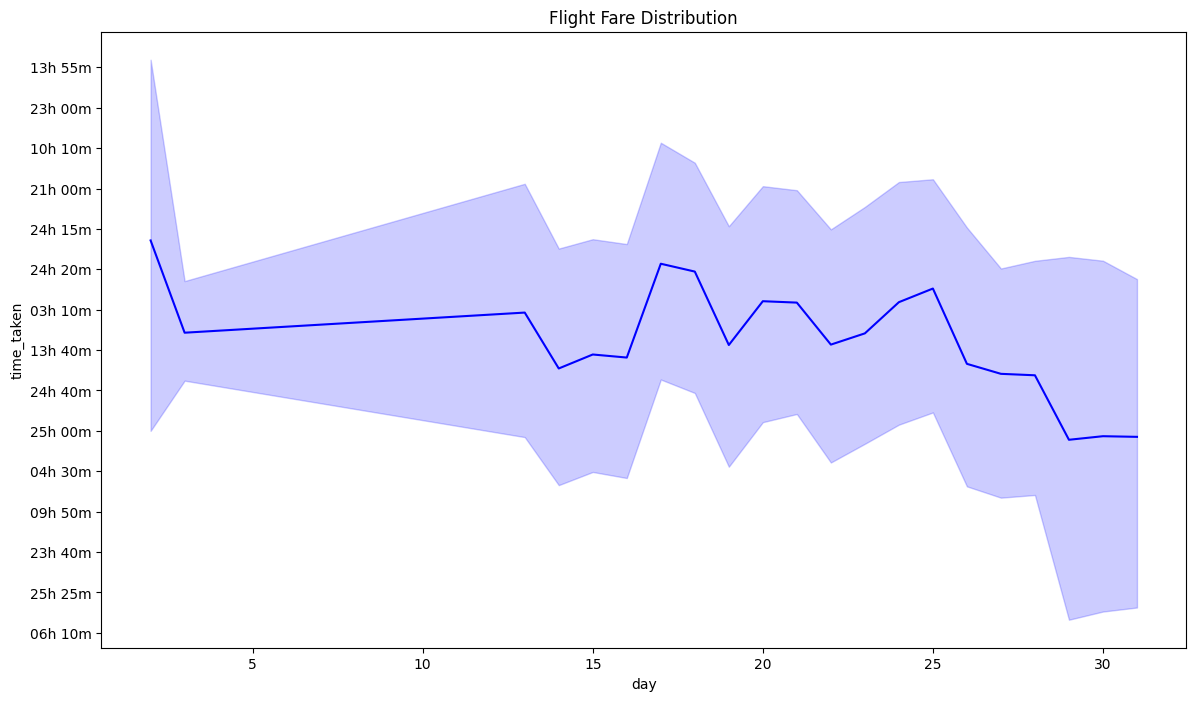

In [377]:
plt.figure(figsize=(14,8))  
plt.title("Flight Fare Distribution")
sns.lineplot(x="day", y="time_taken", data=dataset , color="blue")
plt.show()

In [378]:
dataset["dep_time"] = pd.to_datetime(dataset["dep_time"], format="%H:%M")

In [379]:
dataset["arr_time"] = pd.to_datetime(dataset["arr_time"], format="%H:%M")

In [380]:
dataset["time_taken"] = dataset["arr_time"] - dataset["dep_time"]
dataset["time_taken"] = dataset["time_taken"].dt.total_seconds()

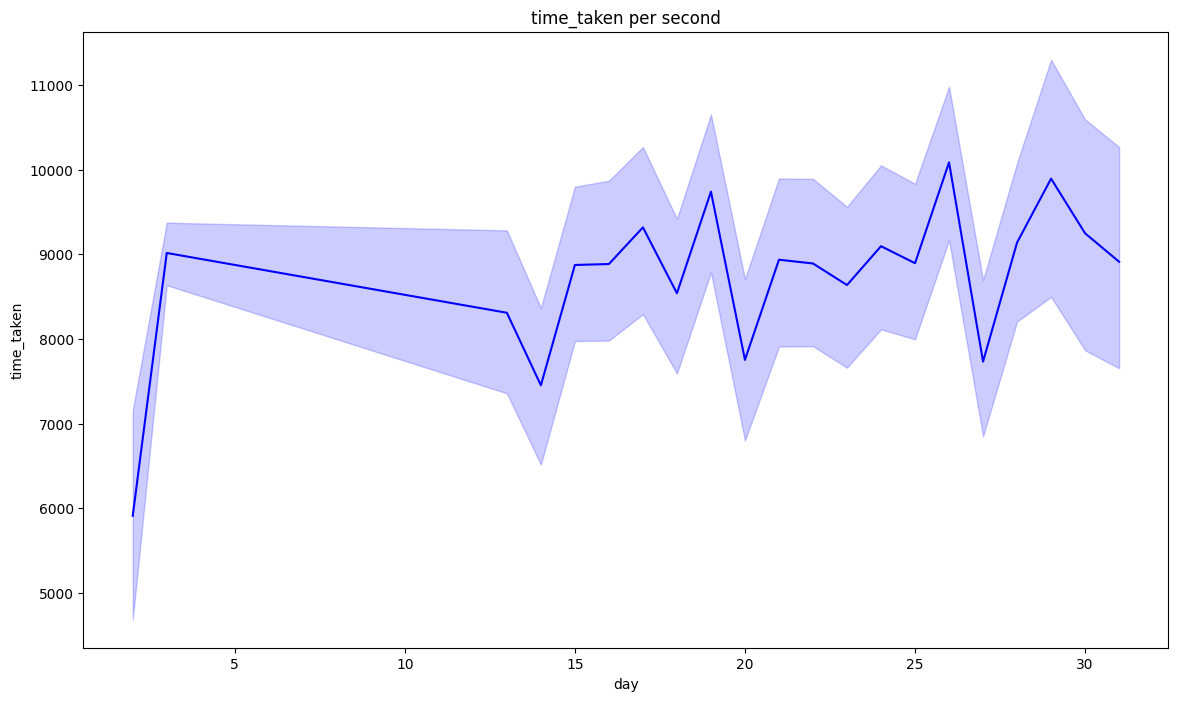

In [381]:
plt.figure(figsize=(14,8))  
plt.title("time_taken per second")
sns.lineplot(x="day", y="time_taken", data=dataset , color="blue")
plt.show()

In [382]:
dataset

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,month,year,day,dayofweek
0,2022-11-02,Air India,AI,868,1900-01-01 18:00:00,Delhi,7200.0,non-stop,1900-01-01 20:00:00,Mumbai,25612.0,11,2022,2,2
1,2022-11-02,Air India,AI,624,1900-01-01 19:00:00,Delhi,8100.0,non-stop,1900-01-01 21:15:00,Mumbai,25612.0,11,2022,2,2
2,2022-11-02,Air India,AI,531,1900-01-01 20:00:00,Delhi,2700.0,1-stop,1900-01-01 20:45:00,Mumbai,42220.0,11,2022,2,2
3,2022-11-02,Air India,AI,839,1900-01-01 21:25:00,Delhi,9000.0,1-stop,1900-01-01 23:55:00,Mumbai,44450.0,11,2022,2,2
4,2022-11-02,Air India,AI,544,1900-01-01 17:15:00,Delhi,24000.0,1-stop,1900-01-01 23:55:00,Mumbai,46690.0,11,2022,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93482,2022-03-31,Vistara,UK,822,1900-01-01 09:45:00,Chennai,36300.0,1-stop,1900-01-01 19:50:00,Hyderabad,69265.0,3,2022,31,3
93483,2022-03-31,Vistara,UK,826,1900-01-01 12:30:00,Chennai,37500.0,1-stop,1900-01-01 22:55:00,Hyderabad,77105.0,3,2022,31,3
93484,2022-03-31,Vistara,UK,832,1900-01-01 07:05:00,Chennai,49800.0,1-stop,1900-01-01 20:55:00,Hyderabad,79099.0,3,2022,31,3
93485,2022-03-31,Vistara,UK,828,1900-01-01 07:00:00,Chennai,36000.0,1-stop,1900-01-01 17:00:00,Hyderabad,81585.0,3,2022,31,3


In [383]:
dataset["time_taken"] = dataset["time_taken"] / 60
dataset["time_taken"] = dataset["time_taken"].astype(int)
dataset["dayofweek"] = dataset["dayofweek"].astype(int)
dataset["month"] = dataset["month"].astype(int)
dataset["year"] = dataset["year"].astype(int)
dataset["day"] = dataset["day"].astype(int)
dataset["price"] = dataset["price"].astype(np.float32)
dataset["num_code"] = dataset["num_code"].astype(object)

In [384]:
dataset.dtypes

date          datetime64[ns]
airline               object
ch_code               object
num_code              object
dep_time      datetime64[ns]
from                  object
time_taken             int64
stop                  object
arr_time      datetime64[ns]
to                    object
price                float32
month                  int64
year                   int64
day                    int64
dayofweek              int64
dtype: object

# FIND OUTLIERS

In [385]:
categorica_cols = dataset.select_dtypes(include=["object"]).columns
categorica_cols
numerical_cols = dataset.select_dtypes(exclude=["object", "datetime64"]).columns
numerical_cols

Index(['time_taken', 'price', 'month', 'year', 'day', 'dayofweek'], dtype='object')

In [386]:
LabelEncoder = LabelEncoder()
for column in categorica_cols:
    dataset[column] = LabelEncoder.fit_transform(dataset[column])
dataset.dtypes

date          datetime64[ns]
airline                int64
ch_code                int64
num_code               int64
dep_time      datetime64[ns]
from                   int64
time_taken             int64
stop                   int64
arr_time      datetime64[ns]
to                     int64
price                float32
month                  int64
year                   int64
day                    int64
dayofweek              int64
dtype: object

In [387]:
dataset

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,month,year,day,dayofweek
0,2022-11-02,0,0,214,1900-01-01 18:00:00,2,120,24,1900-01-01 20:00:00,5,25612.0,11,2022,2,2
1,2022-11-02,0,0,85,1900-01-01 19:00:00,2,135,24,1900-01-01 21:15:00,5,25612.0,11,2022,2,2
2,2022-11-02,0,0,50,1900-01-01 20:00:00,2,45,0,1900-01-01 20:45:00,5,42220.0,11,2022,2,2
3,2022-11-02,0,0,191,1900-01-01 21:25:00,2,150,0,1900-01-01 23:55:00,5,44450.0,11,2022,2,2
4,2022-11-02,0,0,58,1900-01-01 17:15:00,2,400,0,1900-01-01 23:55:00,5,46690.0,11,2022,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93482,2022-03-31,1,1,175,1900-01-01 09:45:00,1,605,0,1900-01-01 19:50:00,3,69265.0,3,2022,31,3
93483,2022-03-31,1,1,179,1900-01-01 12:30:00,1,625,0,1900-01-01 22:55:00,3,77105.0,3,2022,31,3
93484,2022-03-31,1,1,184,1900-01-01 07:05:00,1,830,0,1900-01-01 20:55:00,3,79099.0,3,2022,31,3
93485,2022-03-31,1,1,181,1900-01-01 07:00:00,1,600,0,1900-01-01 17:00:00,3,81585.0,3,2022,31,3


In [388]:
dataset.drop(["date", "dep_time", "arr_time"], axis=1, inplace=True)
dataset

,airline,ch_code,num_code,from,time_taken,stop,to,price,month,year,day,dayofweek
0,0,0,214,2,120,24,5,25612.0,11,2022,2,2
1,0,0,85,2,135,24,5,25612.0,11,2022,2,2
2,0,0,50,2,45,0,5,42220.0,11,2022,2,2
3,0,0,191,2,150,0,5,44450.0,11,2022,2,2
4,0,0,58,2,400,0,5,46690.0,11,2022,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
93482,1,1,175,1,605,0,3,69265.0,3,2022,31,3
93483,1,1,179,1,625,0,3,77105.0,3,2022,31,3
93484,1,1,184,1,830,0,3,79099.0,3,2022,31,3
93485,1,1,181,1,600,0,3,81585.0,3,2022,31,3


In [389]:
for data in dataset.columns:
    print(data, len(dataset[data].unique()))

airline 2
ch_code 2
num_code 264
from 6
time_taken 428
stop 25
to 6
price 2358
month 12
year 1
day 21
dayofweek 7


In [390]:

Q1 = dataset["price"].quantile(0.25)
Q3 = dataset["price"].quantile(0.75)
IQR = Q3 - Q1

outliers = (dataset["price"] < (Q1 - 1.5 * IQR)) | (dataset["price"] > (Q3 + 1.5 * IQR))

clean_dataset = dataset[~outliers]

print(clean_dataset.shape)
clean_dataset

(89837, 12)


,airline,ch_code,num_code,from,time_taken,stop,to,price,month,year,day,dayofweek
0,0,0,214,2,120,24,5,25612.0,11,2022,2,2
1,0,0,85,2,135,24,5,25612.0,11,2022,2,2
2,0,0,50,2,45,0,5,42220.0,11,2022,2,2
3,0,0,191,2,150,0,5,44450.0,11,2022,2,2
4,0,0,58,2,400,0,5,46690.0,11,2022,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
93482,1,1,175,1,605,0,3,69265.0,3,2022,31,3
93483,1,1,179,1,625,0,3,77105.0,3,2022,31,3
93484,1,1,184,1,830,0,3,79099.0,3,2022,31,3
93485,1,1,181,1,600,0,3,81585.0,3,2022,31,3


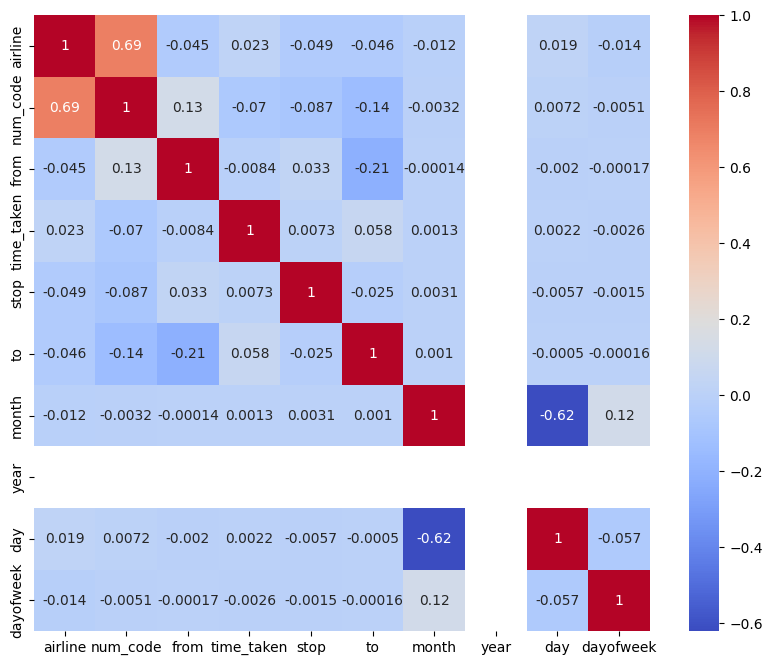

In [391]:
correlation = clean_dataset.drop(["price", "ch_code"], axis=1).corr() 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', square=True)
plt.show()

In [ ]:
StandardScaler = StandardScaler()
numerical_cols = ['airline', 'ch_code', 'num_code', 'from', 'time_taken', 'stop', 'to', 'price', 'month', 'year']
clean_dataset_scaled =  StandardScaler.fit_transform(clean_dataset)
clean_dataset_scaled = pd.DataFrame(clean_dataset_scaled, columns=clean_dataset.columns)
clean_dataset_scaled

In [393]:
clean_dataset_scaled

,airline,ch_code,num_code,from,time_taken,stop,to,price,month,year,day,dayofweek
0,-1.358280,-1.358280,0.752575,-0.315420,-0.052959,3.319244,1.388594,-2.414737,2.683274,0.0,-1.542498,-0.474917
1,-1.358280,-1.358280,-1.103948,-0.315420,-0.023848,3.319244,1.388594,-2.414737,2.683274,0.0,-1.542498,-0.474917
2,-1.358280,-1.358280,-1.607656,-0.315420,-0.198514,-0.327749,1.388594,-0.942657,2.683274,0.0,-1.542498,-0.474917
3,-1.358280,-1.358280,0.421567,-0.315420,0.005263,-0.327749,1.388594,-0.744997,2.683274,0.0,-1.542498,-0.474917
4,-1.358280,-1.358280,-1.492523,-0.315420,0.490445,-0.327749,1.388594,-0.546450,2.683274,0.0,-1.542498,-0.474917
...,...,...,...,...,...,...,...,...,...,...,...,...
89832,0.736225,0.736225,0.191301,-0.882625,0.888295,-0.327749,0.247903,1.454526,-0.268779,0.0,1.576923,0.010670
89833,0.736225,0.736225,0.248867,-0.882625,0.927109,-0.327749,0.247903,2.149438,-0.268779,0.0,1.576923,0.010670
89834,0.736225,0.736225,0.320826,-0.882625,1.324959,-0.327749,0.247903,2.326180,-0.268779,0.0,1.576923,0.010670
89835,0.736225,0.736225,0.277651,-0.882625,0.878591,-0.327749,0.247903,2.546531,-0.268779,0.0,1.576923,0.010670
